# Amateur Hour - Predicting Stocks using LightGBM
### Starter Kernel by ``Magichanics`` 
*([GitHub](https://github.com/Magichanics) - [Kaggle](https://www.kaggle.com/magichanics))*

This is more of an improvement in organization and efficiency compared to my previous notebook. Feel free to post suggestions or criticisms!

## Table of Contents

* [Step 1. Merging Datasets](#section1)
* [Step 2. Feature Engineering](#section2)
* [Step 3. Modelling using LightGBM](#section3)
* [Step 4. Applying the Model](#section4)

In [1]:
import numpy as np
import pandas as pd
import os
import gc
from itertools import chain
import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# import environment for data
from kaggle.competitions import twosigmanews
env = twosigmanews.make_env()

Loading the data... This could take a minute.
Done!


In [4]:
(market_train_df, news_train_df) = env.get_training_data()
write_submission = False # False skips Step 4
sampling = True
if sampling:
    market_train_df = market_train_df.tail(400_000)
    news_train_df = news_train_df.tail(1_000_000)

<a id='section1'></a>
## Step 1. Merging Datasets

While most of the notebooks focuses only on the market dataset, I'm going to attempt on bringing both the news and market dataset together.

In [5]:
market_train_df.head()

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe
3672956,2016-02-19 22:00:00+00:00,SPWR.O,SunPower Corp,4109129.0,21.14,22.25,-0.074431,-0.094055,-0.074354,-0.081761,-0.175828,-0.102823,-0.180055,-0.111746,0.068726,1.0
3672957,2016-02-19 22:00:00+00:00,SQM.N,Sociedad Quimica y Minera de Chile SA,414021.0,17.15,16.94,0.002924,-0.033105,0.002975,-0.025269,0.051502,0.057428,0.049969,0.054736,-0.003696,0.0
3672958,2016-02-19 22:00:00+00:00,SRC.N,Spirit Realty Capital Inc,7481287.0,11.09,11.09,-0.001800,0.024954,-0.001777,0.029012,0.038390,0.052182,0.035912,0.046627,-0.067333,1.0
3672959,2016-02-19 22:00:00+00:00,SRCL.O,Stericycle Inc,898932.0,109.66,111.30,-0.016855,0.004241,-0.016824,0.008331,-0.054166,-0.052121,-0.055767,-0.054056,-0.044206,1.0
3672960,2016-02-19 22:00:00+00:00,SRE.N,Sempra Energy,2143306.0,97.25,96.66,0.003819,0.014058,0.003833,0.015573,0.020355,0.012359,0.019882,0.011141,-0.006034,1.0


In [6]:
news_train_df.head()

,time,sourceTimestamp,firstCreated,sourceId,headline,urgency,takeSequence,provider,subjects,audiences,bodySize,companyCount,headlineTag,marketCommentary,sentenceCount,wordCount,assetCodes,assetName,firstMentionSentence,relevance,sentimentClass,sentimentNegative,sentimentNeutral,sentimentPositive,sentimentWordCount,noveltyCount12H,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D
8328827,2015-12-08 13:56:53+00:00,2015-12-08 13:56:53+00:00,2015-12-08 13:56:53+00:00,f9c4067a6d20f21b,"CHESAPEAKE ENERGY CORP SHARES EXTEND LOSSES, N...",1,1,RTRS,"{'ENER', 'US', 'RTRS', 'CMPNY', 'HOT', 'OILG',...","{'E', 'U'}",0,1,,False,2,21,{'CHK.N'},Chesapeake Energy Corp,1,1.00000,-1,0.819143,0.125228,0.055629,21,2,3,4,7,9,17,23,24,41,63
8328828,2015-12-08 13:57:20+00:00,2015-12-08 13:57:20+00:00,2015-12-08 13:57:20+00:00,749e57557c589fca,REG - Societe Generale SA Anheuser-Busch InBev...,3,1,LSE,"{'NCYC', 'LSE', 'BEVS', 'CMPNY', 'REG', 'NEWR'...",{'LSEN'},21427,1,,False,47,1528,"{'ABI.BR', 'BUD.N'}",Anheuser Busch Inbev SA,1,1.00000,0,0.014524,0.801992,0.183484,62,0,0,0,1,3,22,30,51,90,167
8328829,2015-12-08 13:57:20+00:00,2015-12-08 13:57:19+00:00,2015-12-08 13:57:19+00:00,e61c180b2be5eb45,REG - Societe Generale SA Anheuser-Busch InBev...,3,1,LSE,"{'NCYC', 'LSE', 'BEVS', 'CMPNY', 'REG', 'NEWR'...",{'LSEN'},59958,1,,False,53,4563,"{'ABI.BR', 'BUD.N'}",Anheuser Busch Inbev SA,1,1.00000,1,0.035002,0.161918,0.803080,176,19,25,46,74,133,21,29,50,89,166
8328830,2015-12-08 13:57:37+00:00,2015-12-08 13:57:37+00:00,2015-12-08 13:57:37+00:00,35e01becdbd06d17,IIROC Trade Resumption - BIP.PR.B <BIP.N>,3,1,CNW,"{'ELEU', 'US', 'BISV', 'CMPNY', 'NEWR', 'UTIL'...","{'CNR', 'CNW'}",753,1,,False,8,137,{'BIP.N'},Brookfield Infrastructure Partners LP,4,0.57735,-1,0.811987,0.129426,0.058586,87,1,1,1,1,1,1,1,1,1,10
8328831,2015-12-08 13:57:41+00:00,2015-12-08 13:57:41+00:00,2015-12-08 13:57:41+00:00,36a59986b3a81936,TRANSOCEAN'S U.S.-LISTED SHARES DOWN 2.41 PCT ...,1,1,RTRS,"{'ENEQ', 'ENER', 'RTRS', 'CMPNY', 'HOT', 'EURO...","{'E', 'U'}",0,1,,False,1,14,"{'RIGN.BN', 'RIG.N', 'RIGN.VX'}",Transocean Ltd,1,1.00000,-1,0.819123,0.125241,0.055637,14,0,0,0,1,1,1,3,14,17,17


In [7]:
from datetime import datetime, timedelta
start = datetime(2015, 1, 1, 0, 0, 0).date()
market_train_df = market_train_df.loc[market_train_df['time'].dt.date >= start].reset_index(drop=True)
news_train_df = news_train_df.loc[news_train_df['time'].dt.date >= start].reset_index(drop=True)

### Cleaning Data
We will be removing the rows with the following qualities, as well as features that have almost no correlation with the given data:
* Empty headlines
* Repeat headlines
* Urgency of 2

In [8]:
def clean_data(market_df, news_df, train=True):
    
    # get rid of invalid rows
    news_df = news_df[news_df.headline != '']
    news_df = news_df[news_df.urgency != 2]
    
    # remove duplicate headlines with the same assetCodes
    news_df = news_df.drop_duplicates(subset=['assetCodes', 'headline'],keep='first')
    
    # keep only the following features
#     news_df = news_df[['time', 'assetCodes', 'headline', 'subjects', 'audiences']]
    news_df = news_df[['time', 'assetCodes', 'headline']]
    valid_market_cols = ['time', 'assetCode', 'volume', 'close', 'open',\
                           'returnsClosePrevRaw10', 'returnsOpenPrevRaw10',\
                           'returnsClosePrevMktres10', 'returnsOpenPrevMktres10']
    if train:
        valid_market_cols += ['returnsOpenNextMktres10']
    market_df = market_df[valid_market_cols]

    return market_df, news_df

In [9]:
market_train_df, news_train_df = clean_data(market_train_df, news_train_df, train=True)

In [10]:
news_train_df.shape

(869377, 3)

In [11]:
market_train_df.shape

(400000, 10)

### Expanding News data
We are going to be splitting the news data by assetCode so we could merge the data together. Expanding the News Data works by splitting each news row per assetCode within the assetCodes column. Doing this would allow us to combine the news and market dataset together.

In [12]:
def expanding_news(news_df):
    
    # split to list
    news_output = news_df.copy()
    news_output['assetCodes'] = news_output['assetCodes'].str.findall(f"'([\w\./]+)'")
    
    # separate to assetcodes
    assetCodes_expanded = list(chain(*news_output['assetCodes']))
    assetCodes_index = news_df.index.repeat(news_output['assetCodes'].apply(len))
    assert len(assetCodes_index) == len(assetCodes_expanded)
    df_assetCodes = pd.DataFrame({'level_0': assetCodes_index, 'assetCode': assetCodes_expanded})
    
    # merge to dataframe
    merging_cols = [f for f in news_output if f not in ['assetCodes', 'sourceId']]
    news_df_expanded = pd.merge(df_assetCodes, news_output[merging_cols], left_on='level_0', 
                                right_index=True, suffixes=(['','_old']))
    
    return news_df_expanded

In [13]:
expand_train_df = expanding_news(news_train_df)

In [14]:
expand_train_df.tail()

,level_0,assetCode,time,headline
1608941,999997,SGEN.OQ,2016-12-30 21:57:00+00:00,EQUITY ALERT: Rosen Law Firm Announces Investi...
1608942,999997,SGEN.O,2016-12-30 21:57:00+00:00,EQUITY ALERT: Rosen Law Firm Announces Investi...
1608943,999998,IPDN.O,2016-12-30 21:58:53+00:00,PROFESSIONAL DIVERSITY NETWORK INC - FILES FOR...
1608944,999998,IPDN.OQ,2016-12-30 21:58:53+00:00,PROFESSIONAL DIVERSITY NETWORK INC - FILES FOR...
1608945,999999,JFC.N,2016-12-30 22:00:00+00:00,"JPMorgan China Region Fund, Inc. Board to Subm..."


In [15]:
market_train_df.tail()

,time,assetCode,volume,close,open,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10
399995,2016-12-30 22:00:00+00:00,ZIOP.O,1608829.0,5.35,5.37,-0.165367,-0.138042,-0.139597,-0.135913,0.051189
399996,2016-12-30 22:00:00+00:00,ZLTQ.O,347830.0,43.52,43.62,0.002996,0.002989,0.008213,0.003210,-0.048555
399997,2016-12-30 22:00:00+00:00,ZNGA.O,7396601.0,2.57,2.58,-0.091873,-0.078571,-0.077252,-0.077188,0.011703
399998,2016-12-30 22:00:00+00:00,ZTO.N,3146519.0,12.07,12.50,-0.065066,-0.042146,-0.078104,-0.043813,0.083367
399999,2016-12-30 22:00:00+00:00,ZTS.N,1701204.0,53.53,53.64,0.023127,0.028177,0.026566,0.028719,-0.016220


### Cleaning Headlines
The following will simplify strings to only get the necessary words needed for text processing. This will remove stopwords, and convert all strings into lowercase.

In [16]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import re

ps = PorterStemmer()
sw = stopwords.words('english')

# this takes up a lot of time, so apply it when getting coefficients to filter out words.
def clean_headlines(headline):
    
    # remove numerical and convert to lowercase
    headline =  re.sub('[^a-zA-Z]',' ',headline)
    headline = headline.lower()
    
    # use stemming to simplify words
    headline_words_rough = headline.split(' ')
    
    # check if stopwords are present in headlines
    headline_words = []
    for word in headline_words_rough:
        if word not in sw:
            # use stemming to simplify
            headline_words.append(ps.stem(word))
    
    # join sentence back again
    return ' '.join(headline_words)

### Categorical Groupby
This will merge groups of categorical data together into either lists or sets. The reason why we would need to account for this is that some news rows may have the same associated market row, so in order to account for the overlap, all categorical values such as strings in all rows associated with the same assetCode and time will be combined into a list.

In [17]:
def categorical_groupby(expand_df):

    # get categorical groupbys
    main_cols = ['time', 'assetCode']
    expand_headline_groupby = expand_df[main_cols + ['headline']].groupby(['time', 'assetCode'])
    #expand_cat_groupby = expand_df[main_cols + ['subjects', 'audiences']].groupby(['time', 'assetCode'])
    
    # split subjects and audiences
    def cat_to_list(x):
        try:
            if x.name not in ['time', 'assetCode'] and x.name != 'headline':
                result = []
                for item in x:
                    result += item
                return list(set(result)) # returns unique audiences/subjects
            elif x.name == 'headline':
                return list(x)
        except ValueError:
            return np.nan
    
    # convert groupby to dataframes
#     expand_cat_df = expand_cat_groupby.transform(lambda x: cat_to_list(x))
    expand_headline_df = expand_headline_groupby.transform(lambda x: cat_to_list(x)) # can't iterate through?

    # merge to categorical dataframes
#     return pd.concat([expand_cat_df, expand_headline_df], axis=1)
    return expand_headline_df
    

### Merge by time &  assetCode to News Article
We will be merging rows with the same time and assetCode.

In [18]:
def get_matches(market_df, expand_df):
    
    # get temporary columns as data
    temp_market_df = market_df[['time', 'assetCode']].copy()
    temp_expand_df = expand_df[['time', 'assetCode']].copy()
    
    # get indecies
    temp_expand_df['expand_index'] = temp_expand_df.index.values
    
    # join the two
    temp_expand_df.set_index(['time', 'assetCode'], inplace=True)
    temp_expand_market_df = temp_market_df.join(temp_expand_df, on=['time', 'assetCode'])
    
    # remove nulls
    temp_expand_market_df = temp_expand_market_df[temp_expand_market_df.expand_index.isnull() == False]
    expand_indicies = temp_expand_market_df['expand_index'].tolist()
    
    # do final cleanup
    del temp_market_df
    del temp_expand_df
    
    # fetch matches
    return expand_df.loc[expand_indicies]

def merge_by_code(market_df, expand_df):
    
    # use a copy
    market_df_copy = market_df.copy()
    
    # get expansion of rows
    expand_df = get_matches(market_df, expand_df)
    
    # check if empty
    if len(expand_df) == 0:
        
#         news_cols = ['subjects', 'audiences', 'headline']
        news_cols = ['headline']
        
        # create blank columns of what was supposed to be there
        for f in news_cols:
            market_df_copy[f] = np.nan
        
        return market_df_copy
    
#     # convert to lists
#     expand_df['subjects'] = expand_df['subjects'].str.findall(f"'([\w\./]+)'")
#     expand_df['audiences'] = expand_df['audiences'].str.findall(f"'([\w\./]+)'")
    
    # clean headlines
    expand_df['headline'] = expand_df['headline'].apply(clean_headlines)
    
    # group categoricals
    expand_cat_df = categorical_groupby(expand_df)
    expand_cat_df['time'] = expand_df['time']
    expand_cat_df['assetCode'] = expand_df['assetCode']
    
#     # convert to sets
#     for cat_col in ['subjects', 'audiences']:
#         expand_cat_df[cat_col] = expand_cat_df[cat_col].apply(tuple)
        
    # remove duplicate rows
    expand_cat_df = expand_cat_df.drop_duplicates(subset=['time', 'assetCode'],
                                                  keep='first')
    
    # merge datasets
    expanded_market_df = pd.merge(market_df_copy, expand_cat_df, 
                                  on=['time', 'assetCode'], how='left')
    
    return expanded_market_df
    

In [19]:
%%time
X_train = merge_by_code(market_train_df, expand_train_df)

CPU times: user 1.46 s, sys: 148 ms, total: 1.6 s
Wall time: 1.6 s


In [20]:
X_train[X_train.headline.isnull() == False].head()

,time,assetCode,volume,close,open,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,headline
401,2016-02-22 22:00:00+00:00,ALV.N,436921.0,111.96,108.99,0.126858,0.084695,NaN,NaN,-0.037786,rpt exclus million takata airbag inflat may...
921,2016-02-22 22:00:00+00:00,F.N,33549732.0,12.56,12.24,0.096943,0.062500,0.047356,0.055504,0.027020,rpt exclus million takata airbag inflat may...
1093,2016-02-22 22:00:00+00:00,HMC.N,610950.0,26.11,26.12,0.003845,-0.010231,-0.017810,-0.013049,0.024391,rpt exclus million takata airbag inflat may...
1154,2016-02-22 22:00:00+00:00,IM.N,7136909.0,35.92,36.17,0.294881,0.280807,0.220617,0.269462,-0.058289,ingram micro expand avail acroni ingram micro ...
1921,2016-02-22 22:00:00+00:00,TM.N,297787.0,106.69,106.07,-0.033518,-0.054971,NaN,NaN,-0.036162,rpt exclus million takata airbag inflat may...


Since there are not a lot of news rows that match the same assetCode and time combination, we are left with the following number of rows associated with a row in the market data.

In [21]:
X_train[X_train.headline.isnull() == False].shape[0]

164

While this may be insignificant, there is always a possibility of having more rows that have the same time and assetCode pair in the test dataset, so we will continue to use the news data for our model.

In [22]:
X_train.tail()

,time,assetCode,volume,close,open,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,headline
399995,2016-12-30 22:00:00+00:00,ZIOP.O,1608829.0,5.35,5.37,-0.165367,-0.138042,-0.139597,-0.135913,0.051189,NaN
399996,2016-12-30 22:00:00+00:00,ZLTQ.O,347830.0,43.52,43.62,0.002996,0.002989,0.008213,0.003210,-0.048555,NaN
399997,2016-12-30 22:00:00+00:00,ZNGA.O,7396601.0,2.57,2.58,-0.091873,-0.078571,-0.077252,-0.077188,0.011703,NaN
399998,2016-12-30 22:00:00+00:00,ZTO.N,3146519.0,12.07,12.50,-0.065066,-0.042146,-0.078104,-0.043813,0.083367,NaN
399999,2016-12-30 22:00:00+00:00,ZTS.N,1701204.0,53.53,53.64,0.023127,0.028177,0.026566,0.028719,-0.016220,NaN


In [23]:
def data_step1(market_test_df, news_test_df):
    
    market_test_df, news_test_df = clean_data(market_test_df, news_test_df, train=False)
    expand_test_df = expanding_news(news_test_df)
    X_test = merge_by_code(market_test_df, expand_test_df)
    del market_test_df, news_test_df, expand_test_df
    gc.collect()
    
    return X_test
    

In [24]:
del market_train_df, news_train_df, expand_train_df
gc.collect()

185

<a id='section2'></a>
## Step 2. Feature Engineering

From Quant features to text processing features.

In [25]:
X_train.tail()

,time,assetCode,volume,close,open,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,headline
399995,2016-12-30 22:00:00+00:00,ZIOP.O,1608829.0,5.35,5.37,-0.165367,-0.138042,-0.139597,-0.135913,0.051189,NaN
399996,2016-12-30 22:00:00+00:00,ZLTQ.O,347830.0,43.52,43.62,0.002996,0.002989,0.008213,0.003210,-0.048555,NaN
399997,2016-12-30 22:00:00+00:00,ZNGA.O,7396601.0,2.57,2.58,-0.091873,-0.078571,-0.077252,-0.077188,0.011703,NaN
399998,2016-12-30 22:00:00+00:00,ZTO.N,3146519.0,12.07,12.50,-0.065066,-0.042146,-0.078104,-0.043813,0.083367,NaN
399999,2016-12-30 22:00:00+00:00,ZTS.N,1701204.0,53.53,53.64,0.023127,0.028177,0.026566,0.028719,-0.016220,NaN


### Text Processing with CountVectorizer
We are going to be using CountVectorizer on headlines, audiences and subjects to determine its influence on the target column.

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

class TextToCoeff:

    def vectorize(self, X_):

        # get required dataset
        X_text = X_.copy()[['returnsOpenNextMktres10', self.col]].dropna()

        # round data (if objective : binary)
        def round_scores(x):
            if x >= 0:
                return 1
            else:
                return 0
        X_text['returnsOpenNextMktres10'] = X_text['returnsOpenNextMktres10'].apply(round_scores)

        # convert tuples to string format if applicable
        def tuple_to_str(x):
            try:
                if isinstance(x, tuple):
                    return ' '.join(x)
                else:
                    return x
            except ValueError:
                return np.nan
            
        X_text[self.col] = X_text[self.col].apply(tuple_to_str)

        # get lists
        text_lst = list(X_text[self.col])
        target_lst = list(X_text['returnsOpenNextMktres10'])

        # vectorize text features
        vectorizer = CountVectorizer()
        text_vectorized = vectorizer.fit_transform(text_lst)

        # model data (will use other modelling methods in the future)
        text_model = LogisticRegression()
        text_model = text_model.fit(text_vectorized, target_lst)

        # get coefficients
        basictext = vectorizer.get_feature_names()
        basiccoeffs = text_model.coef_.tolist()[0]
        self.coeff_df = pd.DataFrame({'Text' : basictext, 
                                'Coefficient' : basiccoeffs})

        # convert dataframe to dictionary of coefficients
        self.coeff_dict = dict(zip(self.coeff_df.Text, self.coeff_df.Coefficient))

        # get value that accounts for nulls
        self.coeff_default = self.coeff_df['Coefficient'].mean()

    def predict_data(self, X_):

        def get_coeff(x):
            
            try:

                # iterate through each set of text data
                coeff_total_score = 0
                
                # check if its a tuple or string
                if isinstance(x, tuple):
                    x = ' '.join(x)
                if isinstance(x, str):
                    x = [x]
                
                # iterate through each set
                for textset in x:

                    text_lst = textset.split(' ')
                
                    # iter through every word
                    coeff_sum = 0
                    for text in text_lst:
                        text = text.lower()
                        if text in self.coeff_dict:
                            coeff_sum += self.coeff_dict[text]
                        else:
                            coeff_sum += self.coeff_default

                    # get average coefficient
                    coeff_total_score += coeff_sum / len(text_lst)

                return coeff_total_score / len(x)
            
            except TypeError:
                
                return np.nan

        X_[self.col + '_coeff_mean'] = X_[self.col].apply(get_coeff)
        
        return X_

    # obtain target volumn
    def __init__(self, input_col):
        self.col = input_col

In [27]:
def text_processing_train(X):
    
    # get list of text to coeff converters [headline]
    text_to_coeff_lst = []
    for f in ['headline']:
        text_to_coeff = TextToCoeff(f)
        text_to_coeff.vectorize(X)
        text_to_coeff_lst.append(text_to_coeff)
    
    return text_to_coeff_lst

def text_processing_test(X, text_to_coeff_lst):
    
    for text_to_coeff in text_to_coeff_lst:
        X = text_to_coeff.predict_data(X)
        
    del X['headline']
    gc.collect()
    
    return X

In [28]:
%%time
text_to_coeff_lst = text_processing_train(X_train)
X_train = text_processing_test(X_train, text_to_coeff_lst)

CPU times: user 656 ms, sys: 0 ns, total: 656 ms
Wall time: 662 ms


### Keyword Coefficient Graphs

Here are the coefficients of each keyword found in each headline.

In [29]:
def coeff_df_graph(cf_df, size):
    
    # sort values based on coefficient value
    cf_df = cf_df.sort_values(by=['Coefficient'])
    plt.figure(figsize=size)
    
    # plot graph
    ax = sns.barplot(y="Text", x="Coefficient", data=cf_df)
    

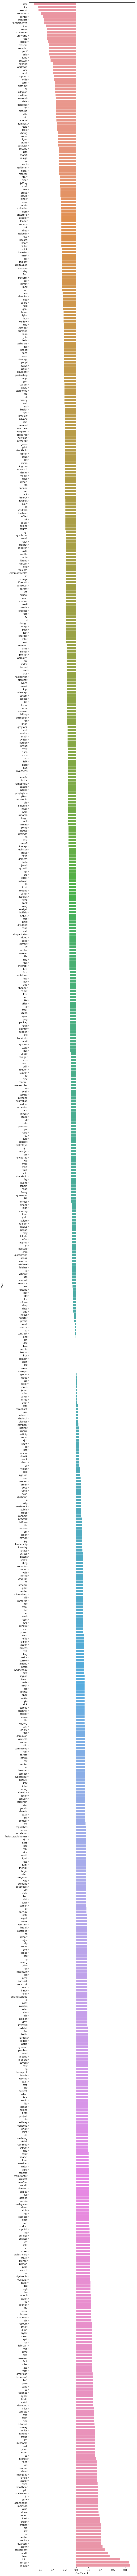

In [30]:
coeff_df_graph(text_to_coeff_lst[0].coeff_df,(8,200))

As seen in the graph, words like health, ceo, inc in news headlines are more likely to cause a stock to go down in value, compared to american, host, senior and retire in news headlines would cause the associated stock to go up.

In [31]:
text_to_coeff_lst[0].coeff_df.shape

(816, 2)

### Entire Market and Individual Asset Lag Features
We are going to be obtaining Quant Features from both the entire market dataframe and from each individual asset based on assetCode. Since it takes a long time to preform this task, we will be using multiprocessing to create these lag features (Moving Average/Max/Min/Standard Deviation) per timeframe and stock based on assetCode.

Source: https://www.kaggle.com/qqgeogor/eda-script-67

In [32]:
from multiprocessing import Pool

def create_lag(df_code,n_lag=[3,7,14,],shift_size=1):
    
    # iterate through each feature
    for col in return_features:
        
        # iterate through each trading window
        for window in n_lag:
            rolled = df_code[col].shift(shift_size).rolling(window=window)
            
            # aggregate rolling values
            lag_mean = rolled.mean()
            lag_max = rolled.max()
            lag_min = rolled.min()
            lag_std = rolled.std()
            df_code['%s_lag_%s_mean'%(col,window)] = lag_mean
            df_code['%s_lag_%s_max'%(col,window)] = lag_max
            df_code['%s_lag_%s_min'%(col,window)] = lag_min
    
    # all columns that lack data will be given the value -1
    return df_code.fillna(-1)

def generate_lag_features(df,n_lag = [3,7,14]):
    
    # gorupby assetCode for getting lag features
    assetCodes = df['assetCode'].unique()
    all_df = []
    df_codes = df.groupby('assetCode')
    df_codes = [df_code[1][['time','assetCode']+return_features] for df_code in df_codes]
    
    # use multiprocessing for time efficiency
    pool = Pool(4)
    all_df = pool.map(create_lag, df_codes)
    
    # add lag features to main dataframe
    new_df = pd.concat(all_df)  
    new_df.drop(return_features+['time', 'assetCode'],axis=1,inplace=True)
    new_df = pd.concat([df, new_df], axis=1, sort=False)
    pool.close()
    
    return new_df

In [33]:
%%time
return_features = ['returnsClosePrevMktres10','returnsClosePrevRaw10','open','close', 'volume']
X_train = generate_lag_features(X_train)

CPU times: user 5.98 s, sys: 1.82 s, total: 7.8 s
Wall time: 40.9 s


In [34]:
X_train.dropna().head()

,time,assetCode,volume,close,open,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,headline_coeff_mean,returnsClosePrevMktres10_lag_3_mean,returnsClosePrevMktres10_lag_3_max,returnsClosePrevMktres10_lag_3_min,returnsClosePrevMktres10_lag_7_mean,returnsClosePrevMktres10_lag_7_max,returnsClosePrevMktres10_lag_7_min,returnsClosePrevMktres10_lag_14_mean,returnsClosePrevMktres10_lag_14_max,returnsClosePrevMktres10_lag_14_min,returnsClosePrevRaw10_lag_3_mean,returnsClosePrevRaw10_lag_3_max,returnsClosePrevRaw10_lag_3_min,returnsClosePrevRaw10_lag_7_mean,returnsClosePrevRaw10_lag_7_max,returnsClosePrevRaw10_lag_7_min,returnsClosePrevRaw10_lag_14_mean,returnsClosePrevRaw10_lag_14_max,returnsClosePrevRaw10_lag_14_min,open_lag_3_mean,open_lag_3_max,open_lag_3_min,open_lag_7_mean,open_lag_7_max,open_lag_7_min,open_lag_14_mean,open_lag_14_max,open_lag_14_min,close_lag_3_mean,close_lag_3_max,close_lag_3_min,close_lag_7_mean,close_lag_7_max,close_lag_7_min,close_lag_14_mean,close_lag_14_max,close_lag_14_min,volume_lag_3_mean,volume_lag_3_max,volume_lag_3_min,volume_lag_7_mean,volume_lag_7_max,volume_lag_7_min,volume_lag_14_mean,volume_lag_14_max,volume_lag_14_min
921,2016-02-22 22:00:00+00:00,F.N,33549732.0,12.56,12.24,0.096943,0.062500,0.047356,0.055504,0.027020,0.005596,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1093,2016-02-22 22:00:00+00:00,HMC.N,610950.0,26.11,26.12,0.003845,-0.010231,-0.017810,-0.013049,0.024391,0.005596,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1154,2016-02-22 22:00:00+00:00,IM.N,7136909.0,35.92,36.17,0.294881,0.280807,0.220617,0.269462,-0.058289,-0.142049,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2586,2016-02-23 22:00:00+00:00,CY.O,7897799.0,7.63,7.61,0.123711,0.064336,0.029607,-0.010520,-0.047362,-0.101695,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2601,2016-02-23 22:00:00+00:00,DDC.N,547468.0,10.81,11.13,-0.010073,-0.011545,-0.013325,-0.019046,0.187705,0.061857,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


### Misc. Features
Inclues the following features:
* Daily Difference
* Bartrend
* Average
* Volume Price

In [35]:
def misc_features(X):
    
    # Adding daily difference
    new_col = X["close"] - X["open"]
    X.insert(loc=6, column="daily_diff", value=new_col)
    X['close_to_open'] =  np.abs(X['close'] / X['open'])
    
    # extra features
    X['bartrend'] = X['close'] / X['open']
    X['average'] = (X['close'] + X['open'])/2
    X['pricevolume'] = X['volume'] * X['close']


In [36]:
misc_features(X_train)

In [37]:
X_train.dropna().tail()

,time,assetCode,volume,close,open,returnsClosePrevRaw10,daily_diff,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,headline_coeff_mean,returnsClosePrevMktres10_lag_3_mean,returnsClosePrevMktres10_lag_3_max,returnsClosePrevMktres10_lag_3_min,returnsClosePrevMktres10_lag_7_mean,returnsClosePrevMktres10_lag_7_max,returnsClosePrevMktres10_lag_7_min,returnsClosePrevMktres10_lag_14_mean,returnsClosePrevMktres10_lag_14_max,returnsClosePrevMktres10_lag_14_min,returnsClosePrevRaw10_lag_3_mean,returnsClosePrevRaw10_lag_3_max,returnsClosePrevRaw10_lag_3_min,returnsClosePrevRaw10_lag_7_mean,returnsClosePrevRaw10_lag_7_max,returnsClosePrevRaw10_lag_7_min,returnsClosePrevRaw10_lag_14_mean,returnsClosePrevRaw10_lag_14_max,returnsClosePrevRaw10_lag_14_min,open_lag_3_mean,open_lag_3_max,open_lag_3_min,open_lag_7_mean,open_lag_7_max,open_lag_7_min,open_lag_14_mean,open_lag_14_max,open_lag_14_min,close_lag_3_mean,close_lag_3_max,close_lag_3_min,close_lag_7_mean,close_lag_7_max,close_lag_7_min,close_lag_14_mean,close_lag_14_max,close_lag_14_min,volume_lag_3_mean,volume_lag_3_max,volume_lag_3_min,volume_lag_7_mean,volume_lag_7_max,volume_lag_7_min,volume_lag_14_mean,volume_lag_14_max,volume_lag_14_min,close_to_open,bartrend,average,pricevolume
387918,2016-12-21 22:00:00+00:00,GOOG.O,1211346.0,794.56,795.84,0.030304,-1.28,0.045782,0.008581,-0.002074,0.009318,0.140616,0.015027,0.030231,0.000888,0.026553,0.049086,0.000888,0.011370,0.049086,-0.028080,0.048131,0.053698,0.041546,0.046112,0.066758,0.027374,0.023147,0.066758,-0.026879,795.793333,800.40,790.22,794.437143,800.40,785.04,778.500714,800.40,744.59,793.806667,796.42,790.80,794.530000,797.85,789.27,779.904286,797.85,747.92,1.542299e+06,2443796.0,951014.0,1.743839e+06,2443796.0,951014.0,1.773797e+06,3017947.0,951014.0,0.998392,0.998392,795.200,9.624871e+08
387919,2016-12-21 22:00:00+00:00,GOOGL.O,1459628.0,812.20,815.72,0.026192,-3.52,0.045862,0.004218,-0.000078,0.013145,0.140616,0.020601,0.039960,0.003058,0.032340,0.054876,0.003058,0.015764,0.054876,-0.028711,0.051228,0.059362,0.044049,0.047988,0.067144,0.028137,0.024758,0.067144,-0.027603,813.653333,818.31,809.28,813.064286,818.31,804.82,796.735000,818.31,761.90,812.513333,815.20,809.84,813.474286,817.89,807.90,798.114286,817.89,764.33,1.711443e+06,2598866.0,1263581.0,1.780074e+06,2598866.0,1263581.0,1.858244e+06,2867074.0,1263581.0,0.995685,0.995685,813.960,1.185510e+09
387982,2016-12-21 22:00:00+00:00,HMC.N,507281.0,30.02,30.08,0.000000,-0.06,0.013136,0.002266,0.024439,0.006083,0.140616,0.034245,0.035138,0.033067,0.033763,0.041578,0.021137,0.033442,0.056021,0.012214,0.024689,0.026164,0.022026,0.023488,0.031762,0.009079,0.030351,0.057183,0.009079,30.146667,30.21,30.10,30.160000,30.21,30.09,29.937857,30.34,29.31,30.163333,30.20,30.13,30.171429,30.30,30.01,30.007143,30.63,29.37,5.667863e+05,854758.0,391865.0,6.697453e+05,1054597.0,391865.0,7.215958e+05,1054597.0,391865.0,0.998005,0.998005,30.050,1.522858e+07
390275,2016-12-22 22:00:00+00:00,PBH.N,363975.0,48.74,49.14,0.047496,-0.40,0.050224,0.023523,0.008091,0.070904,0.147046,-0.043596,0.005349,-0.076473,-0.055516,0.005349,-0.095553,-0.075657,0.005349,-0.118269,0.056050,0.059417,0.053082,0.055421,0.079802,0.023899,0.004650,0.079802,-0.078879,49.586667,49.70,49.51,49.475714,50.42,48.07,48.047857,50.42,46.35,49.303333,49.39,49.20,49.534286,50.20,49.20,48.198571,50.20,46.36,3.317723e+05,358254.0,292139.0,5.680126e+05,1416838.0,292139.0,5.008767e+05,1416838.0,292139.0,0.991860,0.991860,48.940,1.774014e+07
390839,2016-12-22 22:00:00+00:00,XLRN.O,580303.0,26.26,27.15,-0.165820,-0.89,-0.124194,-0.147845,-0.113162,0.032059,0.084749,-0.242522,-0.109602,-0.369297,-0.426109,-0.109602,-0.632957,-0.384752,-0.068863,-0.632957,-0.152812,-0.112080,-0.174785,-0.163599,-0.112080,-0.190307,-0.154126,-0.048755,-0.218009,28.946667,29.88,28.13,29.047143,29.88,28.13,31.130714,37.22,28.13,28.146667,28.80,27.49,28.800000,29.66,27.49,30.529286,36.29,27.49,2.629113e+05,293882.0

In [38]:
def data_step2(X_test):
    
    X_test = generate_lag_features(X_test)
    X_test = text_processing_test(X_test, text_to_coeff_lst)
    misc_features(X_test)
    
    return X_test

<a id='section3'></a>
## Step 3. Modelling using LightGBM

In [39]:
traincols = [f for f in X_train.columns if f not in ['time', 'assetCode', 'universe', 'assetName', \
                                                     'returnsOpenNextMktres10','headline']]

# classify data
y_train = (X_train['returnsOpenNextMktres10'] > 0).astype(int)
X_train = X_train[traincols].fillna(0)

### Fixed Training Split
The reason why we need to do a fixed training test split that fetches the last few rows of the training dataset is to avoid odd results, since randomly choosing rows will cause the validation dataset to be filled with rows with different timestamps.

In [40]:
def fixed_train_test_split(X, y, train_size):
    
    # round train size
    train_size = int(train_size * len(X))
    
    # split data
    X_train, y_train = X[train_size:].values, y[train_size:].values
    X_valid, y_valid = X[:train_size].values, y[:train_size].values
    
    return X_train, y_train, X_valid, y_valid

In [41]:
X_train, y_train, X_valid, y_valid = fixed_train_test_split(X_train, y_train, 0.85)

In [42]:
# Scaling of X values
# keeps range within the max and min
mins = np.min(X_train, axis=0)
maxs = np.max(X_train, axis=0)
rng = maxs - mins
X_train = 1 - ((maxs - X_train) / rng)

### Using LightGBM for modelling

Models from https://www.kaggle.com/qqgeogor/eda-script-67

In [43]:
%%time

import lightgbm as lgb

# these are tuned params found in https://www.kaggle.com/qqgeogor/eda-script-67
x_1 = [0.19000424246380565, 2452, 212, 328, 202]
x_2 = [0.19016805202090095, 2583, 213, 312, 220]

train_data, test_data = lgb.Dataset(X_train, y_train), lgb.Dataset(X_valid, y_valid)

params_1 = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
#         'objective': 'regression',
        'learning_rate': x_1[0],
        'num_leaves': x_1[1],
        'min_data_in_leaf': x_1[2],
#         'num_iteration': x_1[3],
        'num_iteration': 239,
        'max_bin': x_1[4],
        'verbose': 1
    }

params_2 = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
#         'objective': 'regression',
        'learning_rate': x_2[0],
        'num_leaves': x_2[1],
        'min_data_in_leaf': x_2[2],
#         'num_iteration': x_2[3],
        'num_iteration': 172,
        'max_bin': x_2[4],
        'verbose': 1
    }

gbm_1 = lgb.train(params_1,
        train_data,
        num_boost_round=100,
        valid_sets=test_data,
        early_stopping_rounds=5,
#         fobj=exp_loss,
        )

gbm_2 = lgb.train(params_2,
        train_data,
        num_boost_round=100,
        valid_sets=test_data,
        early_stopping_rounds=5,
#         fobj=exp_loss,
        )


[1]	valid_0's binary_logloss: 0.694043
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.699648
[3]	valid_0's binary_logloss: 0.701273
[4]	valid_0's binary_logloss: 0.710554
[5]	valid_0's binary_logloss: 0.714397
[6]	valid_0's binary_logloss: 0.724314
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.694043
[1]	valid_0's binary_logloss: 0.694043
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.699614
[3]	valid_0's binary_logloss: 0.703475
[4]	valid_0's binary_logloss: 0.708422
[5]	valid_0's binary_logloss: 0.705876
[6]	valid_0's binary_logloss: 0.708436
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.694043
CPU times: user 6.26 s, sys: 2.04 s, total: 8.3 s
Wall time: 2.75 s


<a id='section4'></a>
## Step 4. Applying the Model


Predictions will be made through a for loop, and apply all the functions above onto the test dataset.

In [44]:
def get_X(market_test_df, news_test_df):
    X_test = data_step1(market_test_df, news_test_df)
    X_test = data_step2(X_test)
    X_test = X_test[[f for f in X_test.columns if f not in ['time', 'assetCode', 'universe', 'assetName', 'returnsOpenNextMktres10',
                                                          'headline', 'subjects', 'audiences']]].fillna(0).values
    return X_test

def make_predictions(market_obs_df, news_obs_df):
    
    # predict using given model
    X_test = get_X(market_obs_df, news_obs_df)
    X_test = 1 - ((maxs - X_test) / rng)
    prediction_values = (gbm_1.predict(X_test) + gbm_2.predict(X_test))/2
    prediction_values = (prediction_values-prediction_values.min())/(prediction_values.max()-prediction_values.min())
    prediction_values = prediction_values * 2 - 1

    return prediction_values


In [45]:
%%time
if write_submission:
    n_days = 0
    
    for (market_obs_df, news_obs_df, predictions_template_df) in env.get_prediction_days(): # Looping over days from start of 2017 to 2019-07-15

        n_days +=1
        if n_days % 50 == 0:
            print(n_days)

        # make predictions
        predictions_template_df['confidenceValue'] = make_predictions(market_obs_df, news_obs_df)

        # save predictions
        env.predict(predictions_template_df)

    env.write_submission_file()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.91 µs


**Sources:**
* [Market Data NN Baseline by Christofhenkel](https://www.kaggle.com/christofhenkel/market-data-nn-baseline)
* [A simple model using the market and news data by Bguberfain](https://www.kaggle.com/bguberfain/a-simple-model-using-the-market-and-news-data)
* [Amateur Hour - Using Headlines to Predict Stocks by Magichanics](https://www.kaggle.com/magichanics/amateur-hour-using-headlines-to-predict-stocks)
* [Simple Quant Features by Youhanlee](https://www.kaggle.com/youhanlee/simple-quant-features-using-python)
* [>0.64 in 100 lines by rabaman](https://www.kaggle.com/rabaman/0-64-in-100-lines/comments)
* [eda script 67 by qqgeogor](https://www.kaggle.com/qqgeogor/eda-script-67)